In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.sarsalambda import SarsaLambdaAgent
from src.utils import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn-paper')
np.set_printoptions(precision=3, linewidth=80)

## Q-Learning

In [4]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)



In [5]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 50/500, Reward -1000.0, Average Max Reward: -988.8, Total steps 1000.0, Epsilon: 0.72, Alpha: 0.10, Time 0.100
Episode 100/500, Reward -1000.0, Average Max Reward: -703.5, Total steps 1000.0, Epsilon: 0.54, Alpha: 0.10, Time 0.100
Episode 150/500, Reward -312.0, Average Max Reward: -448.5, Total steps 312.0, Epsilon: 0.37, Alpha: 0.10, Time 0.033
Episode 200/500, Reward -224.0, Average Max Reward: -246.3, Total steps 224.0, Epsilon: 0.19, Alpha: 0.10, Time 0.039
Episode 250/500, Reward -204.0, Average Max Reward: -207.2, Total steps 204.0, Epsilon: 0.01, Alpha: 0.10, Time 0.021
Episode 300/500, Reward -174.0, Average Max Reward: -226.6, Total steps 174.0, Epsilon: 0.01, Alpha: 0.10, Time 0.018
Episode 350/500, Reward -160.0, Average Max Reward: -595.9, Total steps 160.0, Epsilon: 0.01, Alpha: 0.10, Time 0.018
Episode 400/500, Reward -185.0, Average Max Reward: -204.8, Total steps 185.0, Epsilon: 0.01, Alpha: 0.10, Time 0.020
Episode 450/500, Reward -355.0, Average Max Reward: -

## Con-RL

In [6]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.05, 
    "e_n":0.005, 
    "l":10, 
    "a":0.5, 
    "b":0.95,
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 200
}

In [112]:
stats_cr = build_conrl_stats(num_episodes, env)

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)

conrl.train(env, num_episodes, stats_cr)

#### Starting training #####


/home/nassim/miniconda3/envs/conrl/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

/home/nassim/miniconda3/envs/conrl/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



Episode 50/500, Average Reward: -987.62, Global Error: 8.24, Total steps 1000.0, Discount: 0.48, Time 0.487
	 MLGNG nodes per action layer: 2 1 6
Episode 100/500, Average Reward: -383.18, Global Error: 32.02, Total steps 1000.0, Discount: 0.23, Time 1.000
	 MLGNG nodes per action layer: 10 10 10
Episode 150/500, Average Reward: -637.02, Global Error: 33.42, Total steps 215.0, Discount: 0.11, Time 1.000
	 MLGNG nodes per action layer: 9 10 9
Episode 200/500, Average Reward: -319.50, Global Error: 62.78, Total steps 179.0, Discount: 0.05, Time 1.000
	 MLGNG nodes per action layer: 10 10 9
Episode 250/500, Average Reward: -229.50, Global Error: 47.05, Total steps 146.0, Discount: 0.02, Time 1.000
	 MLGNG nodes per action layer: 8 10 9
Episode 300/500, Average Reward: -425.70, Global Error: 69.72, Total steps 1000.0, Discount: 0.01, Time 1.000
	 MLGNG nodes per action layer: 4 10 6
Episode 350/500, Average Reward: -960.72, Global Error: 10.87, Total steps 1000.0, Discount: 0.01, Time 1.000

## Statistics

In [113]:
# stats_cr = stats_cr_bck

In [114]:
#stats_cr_bck = stats_cr

In [115]:
from src.plotting import *

act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))


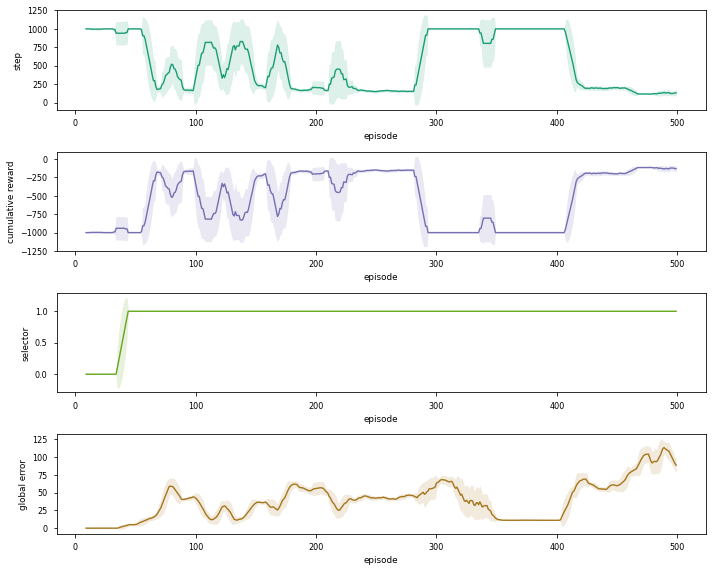

In [116]:
to_plot = ["step", "cumulative_reward", "global_error", "selector"]

stats_to_plot = {key: value for key, value in stats_cr.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
plot_stats(stats_to_plot, figsize=(10, 8))

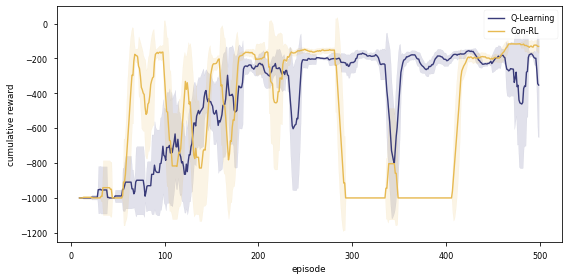

In [117]:
to_plot = ["cumulative_reward"]
plot_stats_comparison({
    "Q-Learning": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
},
title="",
rolling_window=10,
subplots=len(to_plot),
figsize=(8, 4))

In [118]:
tmp = stats_cr["mlgng_nodes"][80].copy()
# tmp[0:2, tmp[2]==0]+= [[0.5], [-0.5]]
# tmp[0:2, tmp[2]==2]+=[[-0.5], [0.5]]

# tmp[0:2, tmp[2]==0]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==0].shape)
# tmp[0:2, tmp[2]==2]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==2].shape)


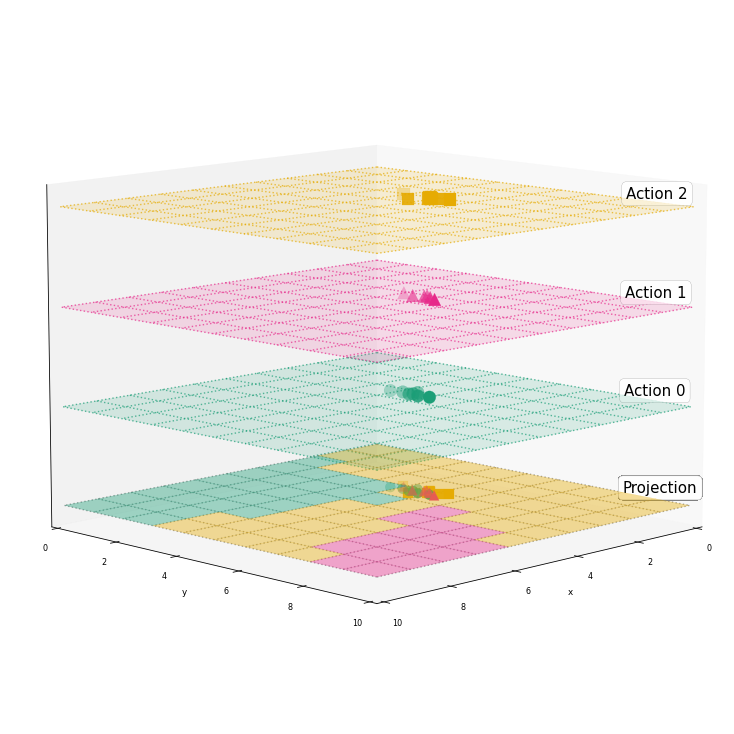

In [119]:
plot_nodes_3d(
            nodes=stats_cr["mlgng_nodes"][80],
            title="",
            policy=stats_cr["best_actions"][80],
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["x", "y", "action"])

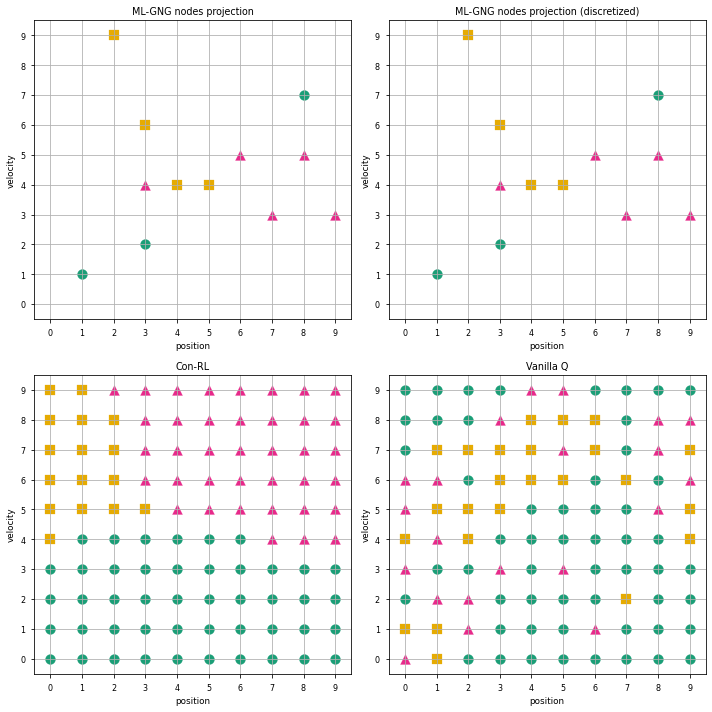

In [120]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection (discretized)",
            round=True,
            def_plot=(fig, ax[1]),)

project_nodes(nodes=conrl.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL",
            def_plot=(fig, ax[2]))

project_nodes(nodes=q_agent.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q",
            def_plot=(fig, ax[3]))

fig.tight_layout()

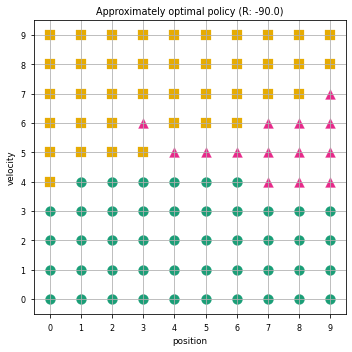

In [121]:
project_nodes(nodes=stats_cr["best_actions"][np.argmax(stats_cr["cumulative_reward"])], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Approximately optimal policy (R: {})".format(stats_cr["cumulative_reward"][np.argmax(stats_cr["cumulative_reward"])]),
            figsize=(5, 5),
            round=True,)

In [122]:
tmp = stats_cr["mlgng_nodes"][70].copy()
tmp[0:2, tmp[2]==0]+= [[0.4], [-0.4]]
tmp[0:2, tmp[2]==2]+=[[-0.4], [0.4]]

tmp[0:2, tmp[2]==0]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==0].shape)
tmp[0:2, tmp[2]==2]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==2].shape)


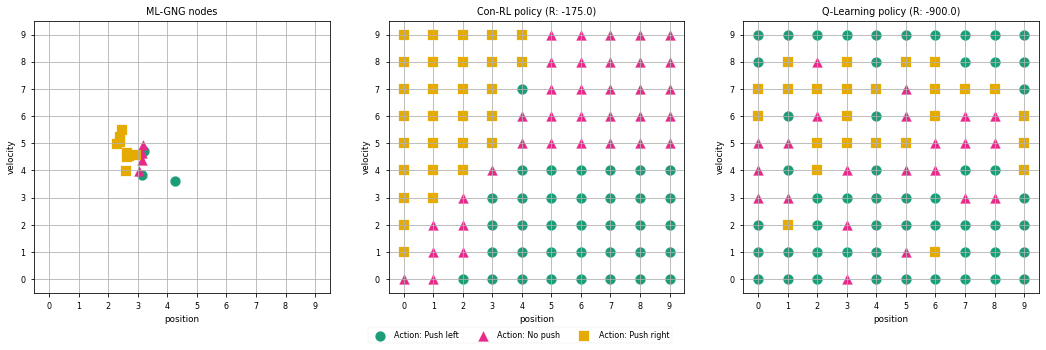

In [123]:

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 70
#fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=tmp, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL policy (R: {})".format(stats_cr["cumulative_reward"][ep]),
            round=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Q-Learning policy (R: {})".format(stats_q["cumulative_reward"][ep]),
            round=True,
            labels=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

No handles with labels found to put in legend.


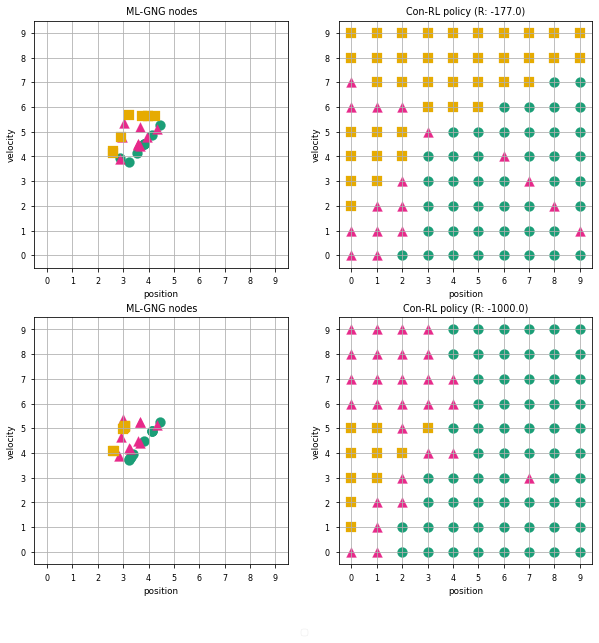

In [134]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

ep = 280
#fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL policy (R: {})".format(stats_cr["cumulative_reward"][ep]),
            round=True,
            def_plot=(fig, ax[1]))

ep=290

project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[2]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL policy (R: {})".format(stats_cr["cumulative_reward"][ep]),
            round=True,
            def_plot=(fig, ax[3]))

fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

In [125]:
act_symbol_plotly = {0:0, 1:5, 2:1}
act_color_plotly = act_color.copy()
act_color_plotly[:, 0:-1]=act_color_plotly[:, 0:-1]*255

In [126]:
plot_nodes_changes(stats_cr["mlgng_nodes"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(stats_cr["best_actions"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)

In [127]:
plot_nodes_changes(stats_cr["mlgng_nodes"][160:170], 
                rewards=stats_cr["cumulative_reward"][160:170],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=1)

In [128]:
# Test MLGNG simplification from near optimal policy
good_policy = stats_cr["best_actions"][np.argmax(stats_cr["cumulative_reward"])][-1].reshape(state_size).astype(int)

stats_opt= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes)
}


for episode in range(num_episodes):
        done = False
        step = 0
        cumulative_reward = 0

        start = time.time()
        state = env.reset()

        while not done:
            action = good_policy[state]
            next_state, reward, done, _ = env.step(action)
            state = next_state
            
            cumulative_reward += reward
            step+=1

        stats_opt["cumulative_reward"][episode] = cumulative_reward
        stats_opt["step"][episode] = step 

            
        end = time.time() - start
        if (episode+1) % 50 == 0:
            print("Episode {}/{}, Average Max Reward: {}, Total steps {}, Time {:.3f}".format(
                episode+1, 
                num_episodes, 
                stats_opt["cumulative_reward"][episode-10:episode].mean(),
                stats_opt["step"][episode],
                end))

Episode 50/500, Average Max Reward: -142.5, Total steps 232.0, Time 0.018
Episode 100/500, Average Max Reward: -144.2, Total steps 172.0, Time 0.014
Episode 150/500, Average Max Reward: -141.1, Total steps 97.0, Time 0.007
Episode 200/500, Average Max Reward: -141.7, Total steps 111.0, Time 0.008
Episode 250/500, Average Max Reward: -147.4, Total steps 187.0, Time 0.016
Episode 300/500, Average Max Reward: -138.9, Total steps 112.0, Time 0.009
Episode 350/500, Average Max Reward: -122.4, Total steps 158.0, Time 0.014
Episode 400/500, Average Max Reward: -137.5, Total steps 177.0, Time 0.015
Episode 450/500, Average Max Reward: -130.6, Total steps 166.0, Time 0.013
Episode 500/500, Average Max Reward: -131.4, Total steps 87.0, Time 0.007


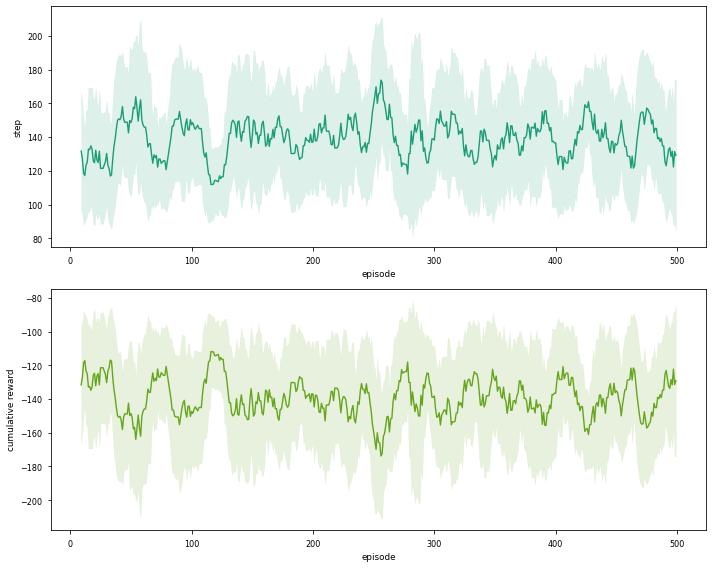

In [129]:
plot_stats(stats_opt, figsize=(10, 8))